In [1]:
import scipy.io
mnist = scipy.io.loadmat('./datasets/mnist-original.mat')

In [2]:
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [3]:
X, y = mnist['data'], mnist['label']

In [4]:
X = X.T

In [5]:
X.shape

(70000, 784)

In [6]:
y = y[0]

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

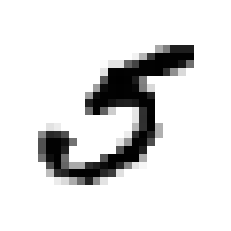

In [8]:
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [9]:
y[36000]

5.0

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
import numpy as np
shuffle_index = np.random.permutation(60000) #把创建随机的index array
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### SGDClassifier

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

###  自定义cross_val_score，实现交叉验证的功能

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

D:\installed\anaconda\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9535
0.9597
0.96435


### sklearn自带的交叉验证

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9535 , 0.9597 , 0.96435])

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9105 , 0.90845, 0.91   ])

### 混淆矩阵

In [19]:
from sklearn .model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
y_train_pred.shape  # 为什么不是三组值？？？

(60000,)

In [21]:
# 混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52928,  1651],
       [  798,  4623]], dtype=int64)

In [22]:
y_train_5.shape

(60000,)

### 精度, 召回率, F1-score
precision = TP / (TP + FP)

recall = TP / (TP + FN)

F1-score = TP/(TP + (FP + FN)/2)

In [28]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # 4623 / (4623 + 1651) = 0.7368504941026458
print(recall_score(y_train_5, y_train_pred)) # 4623 / (4623 + 798) = 0.8527946873270614

0.7368504941026458
0.8527946873270614


In [31]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred) # 4623 / (4623 + (1651 + 798)/2) = 0.7905942710560069

0.7905942710560068

### 调整分类器的判断阈值

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[1600.56850837]


In [34]:
threshold = 0

In [36]:
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


In [37]:
threshold = 2000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [38]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [39]:
# precision_recall_curve 在得到模型预测得分后，使用该方法可以得到各threshold下模型的precision和recall
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [43]:
print(precisions.shape, recalls.shape, thresholds.shape)

(59907,) (59907,) (59906,)


In [45]:
print(precisions)
print(thresholds)

[0.09049177 0.09047659 0.0904781  ... 1.         1.         1.        ]
[-88659.11397617 -88571.94430029 -88465.42379206 ...  41239.85383657
  41494.5675569   41969.01271162]


In [54]:
def plot_precision_recall_cs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.ylim([0, 1])

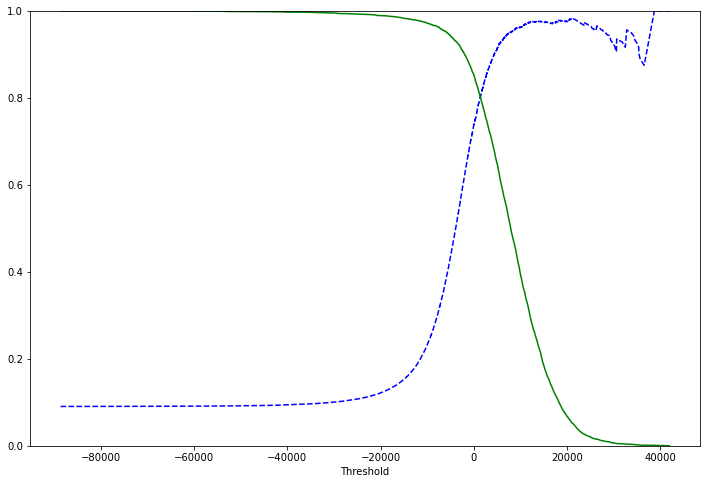

In [55]:
plot_precision_recall_cs_threshold(precisions, recalls, thresholds)
plt.show()

In [70]:
y_train_pred_90 = y_scores > 4400

In [71]:
precision_score(y_train_5, y_train_pred_90)

0.9005158437730287

In [72]:
recall_score(y_train_5, y_train_pred_90)

0.6762589928057554